# Behavior in discrimination-estimation task paradigm

Behavior data summary for Figure 1c-e.

In [1]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import wilcoxon
from statsmodels.stats.weightstats import DescrStatsW

from dynamic_bias import utils
from dynamic_bias.analyses.behavior import PsychometricFunction
from dynamic_bias.analyses.behavior import StimulusSpecificBias
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

utils.setup_matplotlib()

In [2]:
utils.download_dataset("data/outputs/behavior")
behavior = utils.load_behavior()
ssb_fits = utils.load(f'{utils.ORIGIN}/data/outputs/behavior/results_stimulus_specific_bias.pickle')

downloading data/outputs/behavior...
data/outputs/behavior already exists. Skipping download...
downloading data/processed/behavior...
data/processed/behavior already exists. Skipping download...


----
## Psychometric functions

In [4]:
psi = PsychometricFunction()
id_list = np.unique(behavior.ID)
res_mat = utils.nan([len(id_list),2,3])
slopes  = utils.nan([len(id_list),2])
for i_id, v_id in enumerate( id_list ):
    # individual data
    data = {
        'evidence' : -behavior.ref.to_numpy()[behavior.ID==v_id],
        'choice'   : 2.-behavior.choice.to_numpy()[behavior.ID==v_id],
        'cond'     : behavior.Timing.to_numpy()[behavior.ID==v_id],
    }
    
    # fit the psychometric function
    psi.fit(data, constrain_params=['m'])
    res_mat[i_id] = psi.fitted_params
    slopes[i_id]  = psi.slope

# psychometric function slopes
ttest  = DescrStatsW(slopes[:,0]-slopes[:,1])
wilcox = wilcoxon(slopes[:,0]-slopes[:,1])
print("Psychometric function slope: early vs. late")
print('One-sample t-test (two-sided)')
print('t(49)=',  ttest.ttest_mean()[0], 'p=', ttest.ttest_mean()[1])
print('95% CI=', ttest.tconfint_mean())
print('\nWilcoxon signed-rank test (without continuity correction)')
print('V=', wilcox[0], 'p=', wilcox[1])

# lapse rate
ttest  = DescrStatsW(res_mat[:,0,2]-res_mat[:,1,2])
wilcox = wilcoxon(res_mat[:,0,2]-res_mat[:,1,2])
print("\nPsychometric function lapse rate: early vs. late")
print('One-sample t-test (two-sided)')
print('t(49)=',  ttest.ttest_mean()[0], 'p=', ttest.ttest_mean()[1])
print('95% CI=', ttest.tconfint_mean())
print('\nWilcoxon signed-rank test (without continuity correction)')
print('V=', wilcox[0], 'p=', wilcox[1])

Psychometric function slope: early vs. late
One-sample t-test (two-sided)
t(49)= 3.5550856204449177 p= 0.0008485069350326837
95% CI= (0.004789105174133292, 0.017243330316529974)

Wilcoxon signed-rank test (without continuity correction)
V= 302.0 p= 0.0009149367393188612

Psychometric function lapse rate: early vs. late
One-sample t-test (two-sided)
t(49)= 0.8058447697115253 p= 0.42422596094006715
95% CI= (-0.009683619638778796, 0.02264913719627773)

Wilcoxon signed-rank test (without continuity correction)
V= 427.0 p= 0.2149643285968147


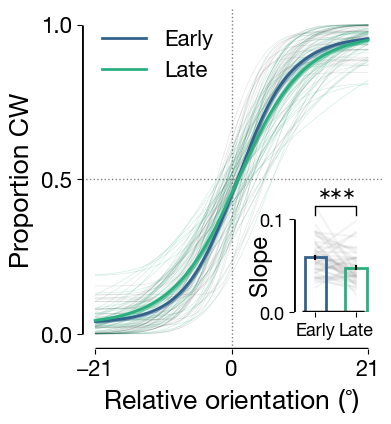

In [4]:
plt.figure()
utils.set_size([3.0,3.4])
ax = plt.gca()

xx  = np.linspace(-21,21,num=200)
my1 = np.mean(np.stack([psi(xx, **dict(zip(psi.param_names, res_mat[i_id,0]))) for i_id in range(50)]),axis=0)
my2 = np.mean(np.stack([psi(xx, **dict(zip(psi.param_names, res_mat[i_id,1]))) for i_id in range(50)]),axis=0)
sy1 = np.std( np.stack([psi(xx, **dict(zip(psi.param_names, res_mat[i_id,0]))) for i_id in range(50)]),axis=0) / np.sqrt(50)
sy2 = np.std( np.stack([psi(xx, **dict(zip(psi.param_names, res_mat[i_id,1]))) for i_id in range(50)]),axis=0) / np.sqrt(50)

ax.axvline(x=0,   linestyle='dotted', color='gray', linewidth=1., zorder=-4)
ax.axhline(y=0.5, linestyle='dotted', color='gray', linewidth=1., zorder=-4)

for i_id, v_id in enumerate( np.unique(behavior.ID) ):
    plt.plot(
        xx, psi(xx, **dict(zip(psi.param_names, res_mat[i_id,0]))),
        color='k', alpha=0.1, linewidth=0.50, zorder=-3
    )
    plt.plot(
        xx, psi(xx, **dict(zip(psi.param_names, res_mat[i_id,1]))),
        color=utils.L_COLOR, alpha=0.2, linewidth=0.50, zorder=-3
    )
    
ax.plot(xx, my1, color=utils.E_COLOR, linewidth=2, label='Early')
ax.plot(xx, my2, color=utils.L_COLOR, linewidth=2, label='Late')
ax.fill_between(xx, my1-sy1, my1+sy1, color=utils.E_COLOR, alpha=0.5, lw=0, zorder=-3)
ax.fill_between(xx, my2-sy2, my2+sy2, color=utils.L_COLOR, alpha=0.5, lw=0, zorder=-3)

# inset
ms1, ss1 = np.mean(slopes[:,0]), np.std(slopes[:,0])/np.sqrt(50)
ms2, ss2 = np.mean(slopes[:,1]), np.std(slopes[:,1])/np.sqrt(50)

ax_inset = inset_axes(ax, width='20%', height='30%', loc='lower right', 
                      bbox_to_anchor=(-0.30, 0.08, 1.30, 1.1), bbox_transform=ax.transAxes)
ax_inset.bar([0,1.5], height=[ms1,ms2], edgecolor=["#33638D", "#29AF7F"], facecolor='None', linewidth=2)
ax_inset.errorbar(x=[0,1.5], y=[ms1,ms2], yerr=[ss1,ss2], fmt="none", color="k")
ax_inset.set_xticks([0,1.5])
ax_inset.set_xticklabels(['Early','Late'], fontsize=13.)
ax_inset.set_ylabel('Slope   ', fontsize=17, labelpad=-10)
ax_inset.tick_params(axis='y', which='major', labelsize=13)
for i in range(50):
    ax_inset.plot([0,1.5], [slopes[i,0],slopes[i,1]], color='gray', alpha=0.09, zorder=-3)
ax_inset.set_xlim((-0.8,2.1))

# significance asterisks
ax_inset.plot( [0, 0, 1.5, 1.5], [0.105, 0.115, 0.115, 0.105], lw=1, c='k' )
ax_inset.text( 0.75, 0.12, r"$ {\ast\!\!\ast\!\!\!\ast} $", ha='center', va='bottom', color='k', fontsize=12 )

utils.draw_publish_axis(ax, xrange=(-21,21), yrange=(0,1), xticks=[-21,0,21], yticks=[0,0.5,1], tight_layout=False)
utils.draw_publish_axis(ax_inset, xrange=(-0.5,1.8), yrange=(0,0.1), xticks=[0,1.5], yticks=[0,0.1], tight_layout=False)

ax.legend(loc='upper left', frameon=False, fontsize=16)
if utils.LABEL:
    ax.set_xlabel(r"Relative orientation $(\!\!^\circ\!\!)$")
    ax.set_ylabel(r"Proportion CW")

plt.savefig(f'{utils.DIR_FIGURE}/fig1c.pdf',bbox_inches='tight', transparent=True)
plt.show()

----
## Stimulus-specific bias

In [5]:
ssb = StimulusSpecificBias()
ssb_funs = utils.nan((len(id_list),240))
for i_id, v_id in enumerate(id_list): 
    ssb_funs[i_id] = ssb(np.arange(180,step=0.75), ssb_fits[v_id])

m_ssb_fun = np.mean(ssb_funs,axis=0)
s_ssb_fun = np.std(ssb_funs,axis=0)/np.sqrt(len(id_list))

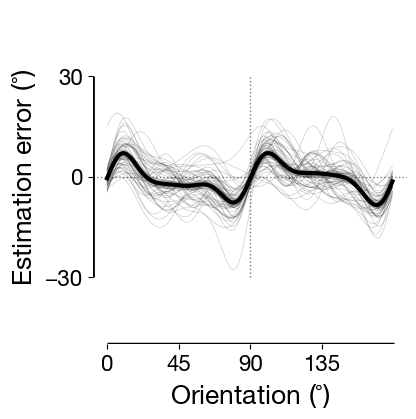

In [6]:
plt.figure()
ax = plt.gca()
utils.set_size([3.4,3.4])

plt.vlines(x=90, ymin=-30, ymax=30, linestyle='dotted', color='gray', linewidth=1.)
plt.axhline(y=0,  linestyle='dotted', color='gray', linewidth=1.)

for i_sub in range(50):
    plt.plot(np.arange(180,step=0.75), ssb_funs[i_sub], color='black', alpha=0.2, linewidth=0.5)

plt.fill_between(np.arange(180,step=0.75), 
                 m_ssb_fun-s_ssb_fun*1.96, 
                 m_ssb_fun+s_ssb_fun*1.96, 
                 color='black', alpha=0.25, linewidth=0)
plt.plot(np.arange(180,step=0.75), m_ssb_fun, color='black', linewidth=3)


plt.ylim([-50,50])
plt.xticks([0,45,90,135])
    
if utils.LABEL:
    plt.xlabel(r"Orientation $(\!\!^\circ\!\!)$")
    plt.ylabel(r"Estimation error $(\!\!^\circ\!\!)$")

utils.draw_publish_axis(ax, xrange=(0,180), yrange=(-30,30), xticks=None, yticks=[-30,0,30])
plt.savefig(f'{utils.DIR_FIGURE}/fig1d.pdf', bbox_inches='tight', transparent=True)
plt.show()

---
## Decision-consistent bias

In [7]:
%%capture
dcb_list = utils.nan((5,2,len(id_list)))
for i_id, v_id in enumerate(id_list): 
    for i_r, v_r in enumerate([-21,-4,0,4,21]): 
        idx = (behavior.ID==v_id) & (behavior.ref== -v_r)
        dcb_list[i_r,0,i_id] = utils.circmean(behavior.error[idx&(behavior.choice==2)])
        dcb_list[i_r,1,i_id] = utils.circmean(behavior.error[idx&(behavior.choice==1)])

dcb_list[0,1] = np.nan # omit the 'lapse' (Far incorrect) conditions for visualization
dcb_list[4,0] = np.nan # omit the 'lapse' (Far incorrect) conditions for visualization
m_dcb_list = np.nanmedian(dcb_list,axis=-1)
s_dcb_list = np.nanstd(dcb_list,axis=-1)/np.sqrt(50) * 1.96

behavior['stim_ref'] = -behavior.ref
behavior['decision'] = 2-behavior['choice']

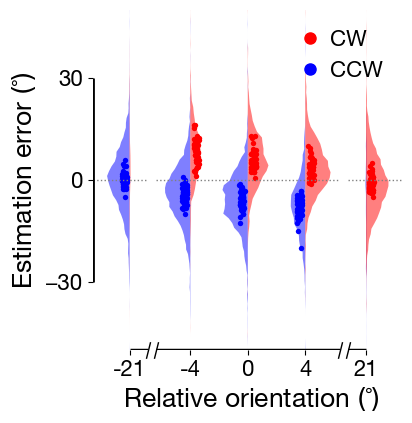

In [8]:
np.random.seed(2023)
f,ax = plt.subplots(1,3, gridspec_kw={'width_ratios':[0.9,3,0.9]})
plt.subplots_adjust(wspace=0.08)
utils.set_size([3.1,3.4])

devi = 0.1 # deviation for scatter plot
for ifig in range(3):
    ax[ifig].axhline(y=0, linestyle='dotted', color='gray', linewidth=1.)

    srs = [[-21],[-4,0,4],[21]][ifig]
    v = sns.violinplot(x="stim_ref", y="error", hue="decision", data=behavior[np.isin(behavior.stim_ref,srs)], 
                       split=True, scale='count', linewidth=0, inner=None, 
                       bw=0.08, palette=['blue','red'], width=0.88, saturation=1, zorder=-1, ax=ax[ifig])
    v.set(xlabel=None, ylabel=None)
    v.get_legend().remove()

    for violin in v.collections:
        violin.set_alpha(0.5)

for i_r, v_r in enumerate([0,0,1,2,0]):
    ifig = [0,1,1,1,2][i_r]
    
    ax[ifig].scatter( np.array([v_r]*50)-devi+ np.random.uniform(-devi/2,devi/2,size=50), 
                      dcb_list[i_r,0,:], color='blue', alpha=1, linewidth=0, s=15, zorder=1)

    ax[ifig].scatter( np.array([v_r]*50)+devi+ np.random.uniform(-devi/2,devi/2,size=50), 
                      dcb_list[i_r,1,:], color='red', alpha=1, linewidth=0, s=15, zorder=1)


# broken axis
d = 4.  # proportion of vertical to horizontal extent of the slanted line
kwargs = dict(marker=[(-1, -d), (1, d)], markersize=12,
              linestyle="none", color='k', mec='k', mew=1, clip_on=False)
ax[0].plot(1,0,transform=ax[0].transAxes, **kwargs)
ax[1].plot(0,0,transform=ax[1].transAxes, **kwargs)
ax[1].plot(1,0,transform=ax[1].transAxes, **kwargs)
ax[2].plot(0,0,transform=ax[2].transAxes, **kwargs)

#
ost = .6 # offset for broken axis
ax[0].set_xlim([0-ost*1.2,0+ost*0.6])
ax[1].set_xlim([0-ost*1.0,2+ost*1.0])
ax[2].set_xlim([0-ost*0.6,0+ost*1.2])
for ifig in range(3):
    ax[ifig].set_ylim([-50,50])
    if ifig >= 1 :
        ax[ifig].spines['left'].set_visible(False)
        ax[ifig].set_yticks([])
ax[0].set_xticklabels([-21])
ax[1].set_xticklabels([-4,0,4])
ax[2].set_xticklabels([21])

# legend
import matplotlib.lines as mlines
circ_red  = mlines.Line2D([], [], color='red', marker='o', linestyle='None', markersize=8, label='CW')
circ_blue = mlines.Line2D([], [], color='blue', marker='o', linestyle='None', markersize=8, label='CCW')
plt.legend(handles=[circ_red, circ_blue], frameon=False, loc='upper right', fontsize=16, handletextpad=-0.1)

if utils.LABEL:
    f.text(0.52, -0.02, r"Relative orientation $(\!\!^\circ\!\!)$", ha='center', fontsize=19)
    ax[0].set_ylabel(r"Estimation error $(\!\!^\circ\!\!)$")

utils.draw_publish_axis(ax[0], xrange=(0,4), yrange=(-30,30), xticks=[0], yticks=[-30,0,30], tight_layout=False)
utils.draw_publish_axis(ax[1], xrange=(-1,4), yrange=None, xticks=[0,1,2], yticks=None, tight_layout=False)
utils.draw_publish_axis(ax[2], xrange=(-1,0), yrange=None, xticks=[0], yticks=None, tight_layout=False)

plt.savefig(f'{utils.DIR_FIGURE}/fig1e.pdf',bbox_inches='tight', transparent=True)
plt.show()